In [1]:
!pip install -q gwpy

In [1]:
%%capture
!pip install transformers
!pip install datasets
import json
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score, classification_report
from transformers import AutoModel, AutoTokenizer, get_scheduler
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import AdamW
from tqdm.notebook import tqdm, trange
from time import perf_counter
from PIL import Image
import pandas as pd
import os
from datasets import load_dataset
# use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [29]:
%%capture
dataset = load_dataset("jxu9001/cs6301project50k")


In [30]:
print(dataset)

DatasetDict({
    test: Dataset({
        features: ['image', 'expression', 'img_width', 'img_height', 'x', 'y', 'w', 'h'],
        num_rows: 10000
    })
    train: Dataset({
        features: ['image', 'expression', 'img_width', 'img_height', 'x', 'y', 'w', 'h'],
        num_rows: 40000
    })
})


In [31]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def show_sample(row_num):
    sample = dataset['train'][row_num]
    print('Index:', row_num)
    print('Text:', sample['expression'])
    fig, ax = plt.subplots()
    rect = patches.Rectangle((sample['x'], sample['y']), sample['w'], sample['h'], linewidth=1, edgecolor='r', facecolor='none')
    print(sample)
    ax.imshow(sample['image'])
    ax.add_patch(rect)



    

Index: 3975
Text: the zebra in the foreground the first zebra
{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=427x640 at 0x7FA48F217EE0>, 'expression': 'the zebra in the foreground the first zebra', 'img_width': 427, 'img_height': 640, 'x': 11.98, 'y': 315.59, 'w': 349.08, 'h': 324.41}
[0.028056206088992976, 0.49310937499999996, 0.8455737704918033, 1.0]


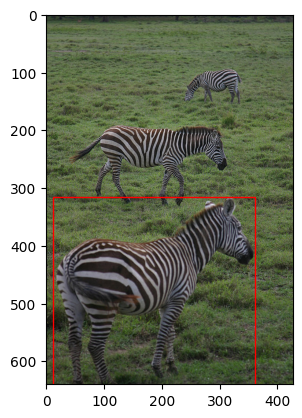

In [82]:
from random import randint
show_sample(3975)
print(resize224(427,640,11.98,315.59,349.08,324.41))

In [32]:
def resize224(image_width, image_height, x, y , w, h):

    (origLeft, origTop, origRight, origBottom) = (x, y, x + w, y + h)

    return [origLeft/image_width, origTop/image_height, origRight/image_width, origBottom/image_height]

def ResNetTransform(image):
    img_size = 224
    mean, std = (0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)
    


    train_transform_func = transforms.Compose(
                [transforms.Resize((img_size, img_size)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
                ])
    
    return train_transform_func(image)


bert_tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')


train_inputs = []
idx = 0
for sample in dataset['train']:
    

    try:
        
        processed_image = ResNetTransform(sample['image'])
        resized_coordinate = resize224(sample['img_width'], sample['img_height'], sample['x'], sample['y'], sample['w'], sample['h'])
        train_inputs.append(
            {
                'text': sample['expression'],
                'image': processed_image,
                'BBox': torch.tensor(resized_coordinate),
                'idx': idx
            }
        )
        

    except:
        pass
    
    idx += 1



test_inputs = []
idx = 0
for sample in dataset['test']:
    

    try:
        
        processed_image = ResNetTransform(sample['image'])
        resized_coordinate = resize224(sample['img_width'], sample['img_height'], sample['x'], sample['y'], sample['w'], sample['h'])
        test_inputs.append(
            {
                'text': sample['expression'],
                'image': processed_image,
                'BBox': torch.tensor(resized_coordinate),
                'idx': idx
            }
        )
        

    except:
        pass
    
    idx += 1

    


In [33]:
train_dataloader = DataLoader(train_inputs, batch_size=50, shuffle=True)
test_dataloader = DataLoader(test_inputs, batch_size=50, shuffle=True)

In [34]:
import torch.nn as nn
from torchvision.models.resnet import resnet50

class ResNetFeatureModel(nn.Module):
    def __init__(self, output_layer):
        super().__init__()
        self.output_layer = output_layer
        pretrained_resnet = resnet50(pretrained=True)
        self.children_list = []
        for n,c in pretrained_resnet.named_children():
            self.children_list.append(c)
            if n == self.output_layer:
                break

        self.net = nn.Sequential(*self.children_list)

        
    def forward(self,x):
        x = self.net(x)
        x = torch.flatten(x, 1)
        return x

In [35]:
class BertResNetModel(nn.Module):
    def __init__(self, text_pretrained='bert-base-uncased'):
        super().__init__()
        self.text_encoder = AutoModel.from_pretrained(text_pretrained)
        self.visual_encoder = ResNetFeatureModel(output_layer='avgpool')
        self.image_hidden_size = 2048

        self.hidden_layer_1 = nn.Linear(self.text_encoder.config.hidden_size + self.image_hidden_size, 512)

        self.attentions = nn.ModuleList()
        self.FFNNs = nn.ModuleList()
        self.norms = nn.ModuleList()
        

        for i in range(6):
            self.attentions.append(nn.MultiheadAttention(512, 8, 0.5))
            self.FFNNs.append(nn.Linear(512,512))
            self.norms.append(nn.LayerNorm(512))

          
        self.output_layer = nn.Linear(512, 4)
        self.dropout = nn.Dropout(0.5)
        self.act_1 = nn.ReLU()
        self.act_2 = nn.Sigmoid()

    def forward(self, text, image):
        text_output = self.text_encoder(**text)
        text_feature = text_output.last_hidden_state[:, 0, :]
        img_feature = self.visual_encoder(image)
        features = torch.cat((text_feature, img_feature), 1)

        x = self.act_1(self.hidden_layer_1(features))

        for attention, FFNN, norm in zip(self.attentions, self.FFNNs, self.norms):
            #x_norm = norm(x)
            attn_output, _ = attention(x, x, x)
            attn_output = self.dropout(attn_output)
            x = norm(x + attn_output)
            x = FFNN(x)
  
            


        prediction_head = self.act_2(self.output_layer(x))

        return prediction_head

In [15]:
resnet_model = BertResNetModel(text_pretrained='bert-base-uncased')
resnet_model = resnet_model.to(device)

In [36]:
def calculate_iou(pred_bbox, gt_bbox):
    x1p, y1p, x2p, y2p = pred_bbox
    x1g, y1g, x2g, y2g = gt_bbox
    
    pred_area = (x2p - x1p + 1) * (y2p - y1p + 1) 
    gt_area = (x2g - x1g + 1) * (y2g - y1g + 1)

    xx1 = max(x1p, x1g) 
    yy1 = max(y1p, y1g) 
    xx2 = min(x2p, x2g) 
    yy2 = min(y2p, y2g) 
    
    w = max(0.0, xx2 - xx1 + 1) 
    h = max(0.0, yy2 - yy1 + 1) 
    intersection = w * h 
    union = pred_area + gt_area - intersection
    
    return intersection / union

SMOOTH = 1e-6

def get_iou(bb1, bb2):


    x_left = max(bb1[0], bb2[0])
    y_top = max(bb1[1], bb2[1])
    x_right = min(bb1[2], bb2[2])
    y_bottom = min(bb1[3], bb2[3])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # compute the area of both AABBs
    bb1_area = (bb1[2] - bb1[0]) * (bb1[3] - bb1[1])
    bb2_area = (bb2[2] - bb2[0]) * (bb2[3] - bb2[1])


    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)

    return iou

def show_sample_bbox(row_num, pred_bbx, gt_bbx):
    sample = dataset['train'][row_num]
    print('Index:', row_num)
    print('Text:', sample['expression'])
    fig, ax = plt.subplots()
    rect1 = patches.Rectangle((gt_bbx[0] * sample['img_width'], gt_bbx[1] * sample['img_height'] ), (gt_bbx[2]-gt_bbx[0]) * sample['img_width'], (gt_bbx[3]-gt_bbx[1]) * sample['img_height'], linewidth=1, edgecolor='r', facecolor='none')
    rect2 = patches.Rectangle((pred_bbx[0] * sample['img_width'], pred_bbx[1] * sample['img_height'] ), (pred_bbx[2]-pred_bbx[0]) * sample['img_width'], (pred_bbx[3]-pred_bbx[1]) * sample['img_height'], linewidth=1, edgecolor='b', facecolor='none')
    ax.imshow(sample['image'])
    ax.add_patch(rect1)
    ax.add_patch(rect2)

In [ ]:
num_train_epochs = 10
learning_rate = 1.0e-5
weight_decay = 0.01
warmup_steps = 0
max_seq_length = 64

train_IoU, test_IoU = [], []

criterion = nn.SmoothL1Loss(reduction = "sum")
optimizer = AdamW(resnet_model.parameters(), lr=learning_rate, weight_decay=weight_decay)

for epoch_num in trange(num_train_epochs, desc='Epochs'):
    epoch_total_loss = 0

    
    
    resnet_model.train()
    data_size = 0
    correct_bbox = 0
    
    for step, batch in enumerate(tqdm(train_dataloader)):      
        
        b_text, b_imgs = batch['text'], batch['image']
        b_BBox = batch['BBox']      
        b_inputs = bert_tokenizer(list(b_text), truncation=True, max_length=max_seq_length,return_tensors="pt", padding =  "max_length")
        b_idx = batch['idx']
        

        b_imgs = b_imgs.to(device)
        b_inputs = b_inputs.to(device)

        resnet_model.zero_grad()        
        BBox_Predicted = resnet_model(text=b_inputs, image=b_imgs).cpu()
 

        for p, t, i in zip(BBox_Predicted.tolist(), b_BBox.tolist(), b_idx.tolist()):
            IoU = get_iou(p, t)

    
            data_size += 1
            if IoU > 0.5:
                correct_bbox += 1


        loss = criterion(BBox_Predicted, b_BBox)
        epoch_total_loss += loss.item()

        loss.backward()
        optimizer.step()
        
    print("Training Accuracy @ 0.5 : ", correct_bbox, data_size, correct_bbox / data_size)
    train_IoU.append(correct_bbox / data_size)
        
        
    resnet_model.eval()
    data_size = 0
    correct_bbox = 0
    
    for step, batch in enumerate(tqdm(test_dataloader)):      
        
        b_text, b_imgs = batch['text'], batch['image']
        b_BBox = batch['BBox']      
        b_inputs = bert_tokenizer(list(b_text), truncation=True, max_length=max_seq_length,return_tensors="pt", padding =  "max_length")
        b_idx = batch['idx']
        

        b_imgs = b_imgs.to(device)
        b_inputs = b_inputs.to(device)

        with torch.no_grad():      
            BBox_Predicted = resnet_model(text=b_inputs, image=b_imgs).cpu()
        #print(BBox_Predicted)
        
        for p, t, i in zip(BBox_Predicted.tolist(), b_BBox.tolist(), b_idx.tolist()):
            IoU = get_iou(p, t)

            data_size += 1
            if IoU > 0.5:
                correct_bbox += 1

        
    print("Testing Accuracy @ 0.5 : ", correct_bbox, data_size, correct_bbox / data_size)
    test_IoU.append(correct_bbox / data_size)
    



In [14]:
resnet_model = BertResNetModel(text_pretrained='bert-base-uncased').to(device)
resnet_model.load_state_dict(torch.load('CS6301_Group10_REC_TFModel_6Layers_epoch_9.pth'))

<All keys matched successfully>

[0.10042721 0.20479426 0.44930035 0.8763651 ] [0.641671875, 0.32134117647058824, 0.7715, 0.7393176470588235]
Index: 464
Text: the left parking meter of the two that are there on a pole


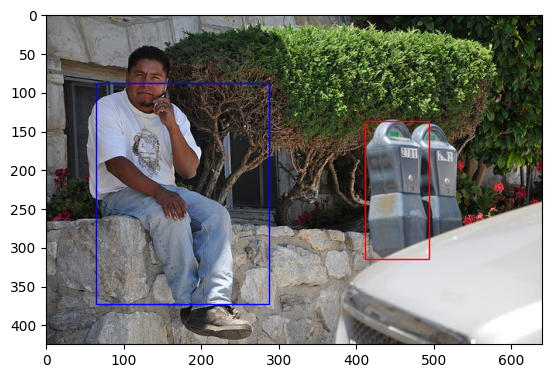

In [97]:
def show_sample_bbox(df, row_num, pred_bbx, gt_bbx):
    sample = df[row_num]
    print('Index:', row_num)
    print('Text:', sample['expression'])
    fig, ax = plt.subplots()
    rect1 = patches.Rectangle((gt_bbx[0] * sample['img_width'], gt_bbx[1] * sample['img_height'] ), (gt_bbx[2]-gt_bbx[0]) * sample['img_width'], (gt_bbx[3]-gt_bbx[1]) * sample['img_height'], linewidth=1, edgecolor='r', facecolor='none')
    rect2 = patches.Rectangle((pred_bbx[0] * sample['img_width'], pred_bbx[1] * sample['img_height'] ), (pred_bbx[2]-pred_bbx[0]) * sample['img_width'], (pred_bbx[3]-pred_bbx[1]) * sample['img_height'], linewidth=1, edgecolor='b', facecolor='none')
    ax.imshow(sample['image'])
    ax.add_patch(rect1)
    ax.add_patch(rect2)


sample_idx = randint(0, 500)
df = dataset['test']
text_input = df[sample_idx]['expression']
image_input = ResNetTransform(df[sample_idx]['image'])
Actual_BBox = resize224(df[sample_idx]['img_width'], df[sample_idx]['img_height'], df[sample_idx]['x'], df[sample_idx]['y'], df[sample_idx]['w'], df[sample_idx]['h'])



resnet_model.eval()

b_BBox = Actual_BBox
b_inputs = bert_tokenizer(text_input, truncation=True, max_length=60,return_tensors="pt", padding =  "max_length")

b_imgs = image_input[None, :].to(device)
b_inputs = b_inputs.to(device)



with torch.no_grad():      
    BBox_Predicted = resnet_model(text=b_inputs, image=b_imgs).cpu()
    
print(BBox_Predicted.numpy()[0], Actual_BBox)

show_sample_bbox(df, sample_idx, BBox_Predicted.numpy()[0], Actual_BBox)
